<a href="https://colab.research.google.com/github/praymesh/Fine_Tuned_LLAMA2/blob/main/finetuningLLM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Installing necessary packages (this is google colab environment)

In [ ]:
#!pip install --upgrade bitsandbytes
!pip install -q accelerate peft transformers trl datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 318.9/318.9 kB 8.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 485.4/485.4 kB 24.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 6.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 11.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 20.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 38.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 37.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [ ]:
!pip install bitsandbytes==0.41.1 #Google Colab comes with CUDA 12.4, bitsandbytes 0.41.1 (compatible with CUDA 12)

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 92.6/92.6 MB 8.3 MB/s eta 0:00:00


In [ ]:
#%pip install -q accelerate==0.21.0 peft==0.4.0 bitsandbytes==0.40.2 #transformers==4.48.3

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
trl 0.15.2 requires accelerate>=0.34.0, but you have accelerate 0.21.0 which is incompatible.


## Importing Necessary Libraries

In [ ]:
import os
import numpy
import pandas
import torch
from datasets import load_dataset
from transformers import(
    AutoModelForCausalLM, #pretrained causal language model
    AutoTokenizer,     #
    BitsAndBytesConfig, #for configuring quantization
    HfArgumentParser, #cmd arguments
    TrainingArguments,
    pipeline,
    logging,
    GenerationConfig,
)
from peft import LoraConfig, PeftModel # Parameter efficient fine tuning and Low rank Adpation
from trl.trainer.sft_trainer import SFTTrainer #Supevised Fine tuning-SFT



In [ ]:

# Check for CUDA availability
if torch.cuda.is_available():
    device = torch.device("cuda")
    print("Using CUDA device:", torch.cuda.get_device_name(0))
else:
    device = torch.device("cpu")
    print("CUDA is not available, using CPU instead.")




Using CUDA device: Tesla T4


# We need data for fine tuning LLama2
LLama2 requires data to be of a specific prompt template(for chat models) :
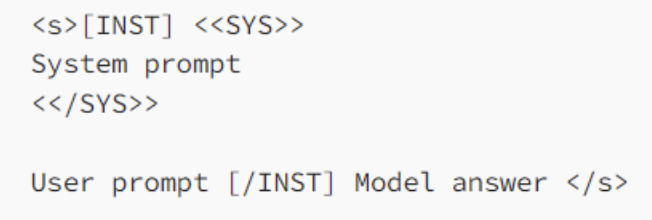

We will reformat our instruction dataset to follow Llama 2 template.
Orignal Dataset: https://huggingface.co/datasets/LDJnr/Puffin.

We will Reformat Dataset following the Llama 2 template:


In [ ]:
!pip install datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 485.4/485.4 kB 9.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 6.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 8.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 12.0 MB/s eta 0:00:00


In [ ]:
from datasets import load_dataset
import json
dataset = load_dataset('LDJnr/Puffin')
#print(dataset)
dataset_list = (dataset)["train"]
print(dataset_list)




Dataset({
    features: ['id', 'conversations'],
    num_rows: 3000
})


In [ ]:
dataset_list[0]

{'id': 1,
 'conversations': [{'from': 'human',
   'value': 'How do I center a text element vertically in a row in jetpack compose? The height of the row is determined by a button next to the text element.'},
  {'from': 'gpt',
   'value': 'In Jetpack Compose, you can center a text element vertically within a row by using the `Arrangement.Center` parameter for the `verticalAlignment` property in the `Row` composable. Here\'s an example:\n```kotlin\nimport androidx.compose.foundation.layout.Arrangement\nimport androidx.compose.foundation.layout.Row\nimport androidx.compose.material.Button\nimport androidx.compose.material.Text\nimport androidx.compose.runtime.Composable\nimport androidx.compose.ui.Alignment\n\n@Composable\nfun CenteredTextWithButton() {\n    Row(\n        verticalAlignment = Alignment.CenterVertically\n    ) {\n        Text("Centered Text")\n        Button(onClick = { /* Do something on button click */ }) {\n            Text("Button")\n        }\n    }\n}\n```\nIn this ex

In [ ]:
# Function to transform the dataset
def transform_dataset(example_dataset):
    transformed_dataset = []
    for item in example_dataset:
        conversations = item["conversations"]
        formatted_conversation = ""
        for i in range(0, len(conversations)-1, 2):
            instruction = conversations[i]["value"] #Getting the instruction(odd index)
            response = conversations[i + 1]["value"]  #Getting the response(even index)
            formatted_conversation += f"<s>[INST] {instruction} [/INST] {response} </s>\n"
        transformed_dataset.append(formatted_conversation.strip())
    return transformed_dataset

# Transform the dataset
transformed_dataset = transform_dataset(dataset_list)

# Save the transformed dataset to a text file
output_file = "transformed_dataset.txt"
with open(output_file, "w") as f:
    for conversation in transformed_dataset:
        f.write(conversation + "\n\n")

Explanation:print(f"Dataset transformed and saved to {output_file}")


Dataset transformed and saved to transformed_dataset.txt


In [ ]:
print(transformed_dataset[0])

<s>[INST] How do I center a text element vertically in a row in jetpack compose? The height of the row is determined by a button next to the text element. [/INST] In Jetpack Compose, you can center a text element vertically within a row by using the `Arrangement.Center` parameter for the `verticalAlignment` property in the `Row` composable. Here's an example:
```kotlin
import androidx.compose.foundation.layout.Arrangement
import androidx.compose.foundation.layout.Row
import androidx.compose.material.Button
import androidx.compose.material.Text
import androidx.compose.runtime.Composable
import androidx.compose.ui.Alignment

@Composable
fun CenteredTextWithButton() {
    Row(
        verticalAlignment = Alignment.CenterVertically
    ) {
        Text("Centered Text")
        Button(onClick = { /* Do something on button click */ }) {
            Text("Button")
        }
    }
}
```
In this example, the `Text` element will be centered vertically in the `Row`, and the height of the row will

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:

output_file = "/content/drive/My Drive/llama2_dataset/transformed_dataset.txt"

with open(output_file, "w") as f:
    for conversation in transformed_dataset:
        f.write(conversation + "\n\n")

print(f"Dataset transformed and saved to Google Drive at {output_file}")



Dataset transformed and saved to Google Drive at /content/drive/My Drive/llama2_dataset/transformed_dataset.txt


In [ ]:
from google.colab import files
files.download("transformed_dataset.txt")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
 !pip install huggingface_hub
from huggingface_hub import notebook_login

notebook_login()

In [ ]:
#!pip install -q -U bitsandbytes

In [ ]:
#!pip install git+https://github.com/TimDettmers/bitsandbytes.git

# Data setup

In [ ]:
with open(output_file, "r") as f:
    dataset = f.readlines()  # Read line-by-line

print(dataset[0])

# Loading The Model,then we have to apply some preprocessing to the model to prepare it for training. For that use the **prepare_model_for_kbit_training method** from PEFT.

In [ ]:
model_one = "meta-llama/Llama-2-7b-chat-hf" #accessed via meta on Huggingface : model_id = "meta-llama/Llama-2-13b-chat-hf"

bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_use_double_quant=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.bfloat16
)
tokenizer = AutoTokenizer.from_pretrained(model_one)
model = AutoModelForCausalLM.from_pretrained(model_one, quantization_config=bnb_config, device_map={"":0})

tokenizer_config.json:   0%|          | 0.00/1.62k [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/500k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.84M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/414 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/614 [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/26.8k [00:00<?, ?B/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/9.98G [00:00<?, ?B/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/3.50G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/188 [00:00<?, ?B/s]

In [ ]:
from peft import prepare_model_for_kbit_training

model.gradient_checkpointing_enable()
model = prepare_model_for_kbit_training(model)

Checking for Total Params

In [ ]:
def print_trainable_parameters(model):
    #Prints the number of trainable parameters in the model.

    trainable_params = 0
    all_param = 0
    for _, param in model.named_parameters(): # _ refers to param name(str) and pram is paramter itslef, which will be dealing with
        all_param += param.numel() #.numel returns the total number of elements in the Model (trainable and non trainable)
        if param.requires_grad: #checks if the parameter is trainable
            trainable_params += param.numel()
    print(
        f"trainable params: {trainable_params} || all params: {all_param} || trainable%: {100 * trainable_params / all_param}"
    )

LORA configuration

In [ ]:
from peft import LoraConfig, get_peft_model

config = LoraConfig(
    r=8, #since we have a smaller dataset, we choose LoRa rank =8
    lora_alpha=32,
    # target_modules=["query_key_value"],
    target_modules=["self_attn.q_proj", "self_attn.k_proj", "self_attn.v_proj", "self_attn.o_proj"], #specific to Llama models.
    lora_dropout=0.05,
    bias="none",
    task_type="CAUSAL_LM"
)

model = get_peft_model(model, config) # wraps the original model with LoRA
print_trainable_parameters(model)

# Training

In [ ]:
# needed for Llama tokenizer
tokenizer.pad_token = tokenizer.eos_token # </s>

trainer = transformers.Trainer(
    model=model,
    train_dataset=data["train"],
    args=transformers.TrainingArguments(
        per_device_train_batch_size=1,
        gradient_accumulation_steps=4,
        warmup_steps=2,
        max_steps=10,
        learning_rate=2e-4,
        fp16=True,
        logging_steps=1,
        output_dir="outputs",
        optim="paged_adamw_8bit"
    ),
    data_collator=transformers.DataCollatorForLanguageModeling(tokenizer, mlm=False),
)
model.config.use_cache = False  # silence the warnings. Please re-enable for inference!
trainer.train()